## INF250 Mandatory 2

The task is to remove all M&Ms and broken nonstops from the image. 

First thing I do is that I import the image, and show it. For this task I use the blue channel of the RGB image, because it reduced the size of the holes in the image, therefore making them easier to deal with. 

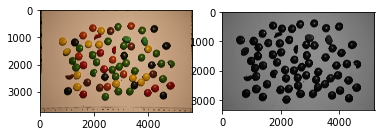

In [229]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from skimage import filters, morphology, segmentation
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import measure
import math

filepath = "../images/IMG_2754_nonstop_alltogether.JPG"
image = io.imread(filepath)
fig, axes = plt.subplots(ncols=2)
ax = axes.ravel()
ax[0].imshow(image, cmap='gray')
image = image[:,:,2] #Using the blue channel of the image.
image = image[200:-200, 200:-200] # Crop image to remove noisy borders.

ax[1].imshow(image, cmap='gray')



Now I threshold the image to create a binary image. 

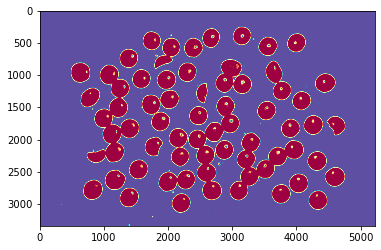

In [230]:
# Otsu threshold
thresh = filters.threshold_otsu(image)
otsu_im = image > thresh
plt.imshow(otsu_im, cmap='Spectral')


To close the holes in the image, I use the technique called opening. 

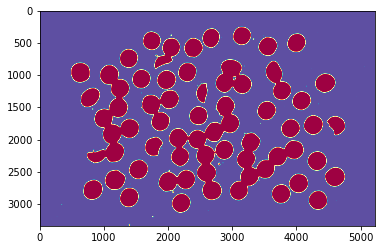

In [231]:
# Opening

opened_im = morphology.opening(otsu_im, morphology.square(22))
plt.imshow(opened_im, cmap='Spectral')

Watershed helps identify the different objects in the image. 

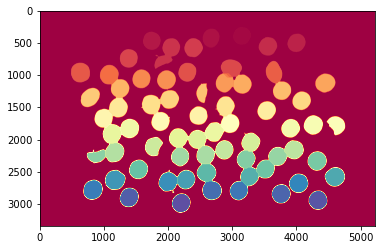

In [232]:
# Watershed


im = np.invert(opened_im)
distance = ndi.distance_transform_edt(im)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=im, min_distance=30, num_peaks=70)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = segmentation.watershed(-distance, markers, mask=im, watershed_line=True)
plt.imshow(labels, cmap='Spectral')


Next I use the measure module from skimage. First I use the label function to find connected regions, and then I use the regionprops function that creates regionproperties, which have a lot of attributes, some which I have used here. 

I use circularity and roundness to distinguish between nonstops and M&Ms/broken nonstops. I tested different values, to see which worked best as a threshold, and I found that 0.8 seemed to work best for both circularity and roundness. Below I have plotted the histograms for both circularity and roundness and 0.8 seems a reasonable threshold for the image. 

In [233]:
# Measure

labels2 = measure.label(labels)
properties = measure.regionprops(labels2)

circularity = []
mask = np.ones(np.shape(image))
round_list = []
for ix, prop in enumerate(properties):
    if prop.perimeter != 0:
        circ = 4*math.pi*prop.area/prop.perimeter**2
        circularity.append(circ)
        roundness = 4*(prop.area/(math.pi*prop.axis_major_length**2))
        round_list.append(roundness)
        if circ < 0.8 or roundness < 0.8: 
            for ix, coords in enumerate(prop.coords):
                mask[coords[0]][coords[1]] = 0
        

(array([ 1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         1.,  1.,  0.,  1.,  5., 15., 42.]),
 array([0.12021143, 0.15938338, 0.19855534, 0.23772729, 0.27689924,
        0.3160712 , 0.35524315, 0.39441511, 0.43358706, 0.47275902,
        0.51193097, 0.55110293, 0.59027488, 0.62944684, 0.66861879,
        0.70779075, 0.7469627 , 0.78613465, 0.82530661, 0.86447856,
        0.90365052]),
 <BarContainer object of 20 artists>)

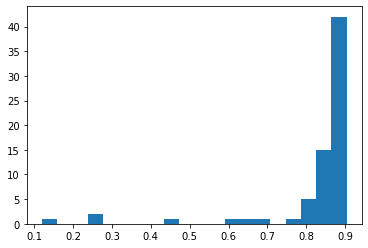

In [234]:
plt.hist(circularity, bins=20)


(array([ 1.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,
         0.,  3.,  2.,  0.,  1., 13., 45.]),
 array([0.03815513, 0.08540742, 0.13265972, 0.17991201, 0.2271643 ,
        0.27441659, 0.32166889, 0.36892118, 0.41617347, 0.46342577,
        0.51067806, 0.55793035, 0.60518264, 0.65243494, 0.69968723,
        0.74693952, 0.79419182, 0.84144411, 0.8886964 , 0.93594869,
        0.98320099]),
 <BarContainer object of 20 artists>)

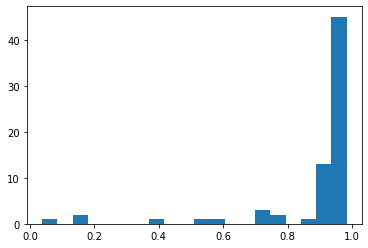

In [235]:
plt.hist(round_list, bins=20)

Next I plot the mask, this is the section of the image that is to be removed. All the M&Ms and broken nonstops seemed to have been removed, but there are some whole nonstops that have also been removed, that shouldn't have been. It is possible that the parameters in the watershed function should have been different, or that different geometrical features should have been used to seperate the M&Ms and nonstops. 

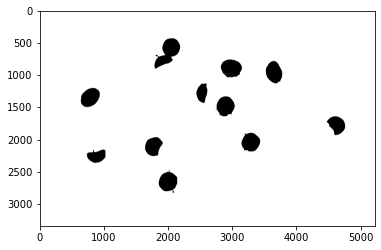

In [236]:
plt.imshow(mask, cmap='gray')


The image with the M&Ms and broken nonstops removed is plotted below. 

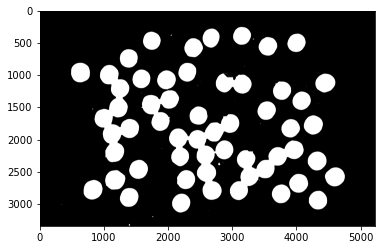

In [215]:
plt.imshow(im*mask, cmap='gray')